In [1]:
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d",
    resource_group = "azurequantum",
    name = "qchack-2022-b",
    location = "eastus"
)


In [1]:
pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


**_Due to the limite of hackathon timeline, I have to use the qiskit Aer for running the simulation_**

In [2]:
pip install qiskit-aer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/b0c3bbe3-7123-4ba4-9aa2-57d9845f4a1d/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qchack-2022-b",
    location = "eastus"
)

# **Import necessary package**

In [3]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import COBYLA
import numpy as np 
from numpy import sqrt, pi, linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, PauliOp
from qiskit import execute

# Preparing the general ansatz that can cover all quantum Hilbert space to be able to reach the desired state

## **The first step to solve VQE problem is finding an efficient ansatz that reach the desired state and be as short depth as possible. **

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
For general purpose, we will create a general state $\ket{\Psi}$ from the $\ket{0}^{\otimes n}$ by controll-$U3(\theta,\phi)$ gate. The state $\ket{\Psi}$ can reaches entire quantum Hilbert space

In [4]:
# Prepare general State Circuit (n Qubit)-Multicontrol qubit
def PrepareState_Gen(parameter,q = 2):
    # Multi control U3 gate
    def MCUGate(p1,p2,ctrlqubit):
        ctrl = QuantumCircuit(1, name='U3')
        # U3 decompose
        ctrl.rz(p2,0)
        ctrl.rx(-np.pi/2,0)
        ctrl.rz(p1,0)
        ctrl.rx(np.pi/2,0)
        ctrl.rz(-p2,0)
        # U3 decompose
        ctrl = ctrl.to_gate().control(ctrlqubit)
        return ctrl
    # State's bit string converter
    def Bitstring(inter,leng):
        result = []
        while inter >= 2:
            d = inter % 2
            inter = inter//2
            result.append(d)
        result.append(inter)
        for i in range(leng-len(result)):
            result.append(0)
        return result

    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    qc.u(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    # Apply multi-control qubit gate
    for i in range(q-1):
        listctrl = [ i+n+1 for n in range(q-i-1)]
        listctrl.append(i)
        for j in range(2**(q-i-1)):
            bitstring = Bitstring(j,q-i-1)
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1)
            qc.append(MCUGate(parameter[theta],parameter[theta+1],q-i-1),listctrl) 
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1) 
            theta +=2
        qc.barrier(range(q))
    return qc

## **Drawing the general ansatz with $2^{q+1}-2$ parameters**

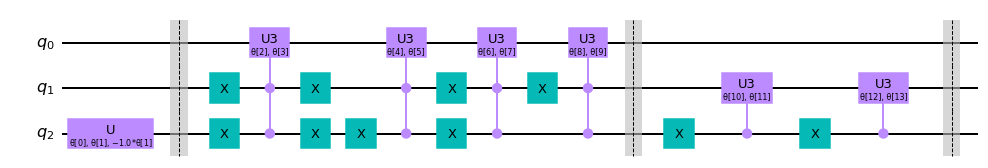

In [36]:
q = 3
parameters = ParameterVector('θ', 2**(q+1)-2)
Gen_State = PrepareState_Gen(parameters,q)
Gen_State.draw(output='mpl')

**_Next step, we will implement the specific problem in VQE, namely the Ising model, to investigate some improvement we can make for running and taking advantage on real quantum device, NISQ device particularly _**

# Pauli operators expectation value

To measure the Hamilton of Ising, we need construct the function to measure the Pauli operator expectation value:
$$\text{from the formula} \sigma_Z $$
$$\bra{\Psi}\sigma_Z^1\ket{\Psi} = 2P_z(q_0=0) - 1 $$
$$\bra{\Psi}\sigma_Z^1\otimes\sigma_Z^1\ket{\Psi} = 4P_z(q_0q_1=00) -2P_z(q_0=0)-2P_z(q_1=0) - 1 $$

In [46]:
def Expectation_Exact(gate=None,q1=None,q2=None,circ=None):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    if gate == "ZZ": # Measure two Pauli Z 
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult = (4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Z":
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "X": # Measure one Pauli X
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult = (2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "YY": # Measure two Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.sdg(q2) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q2) # Apply H gate to apply X basic measurement
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult = (4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Y": # Measure one Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult = (2*P[0]-1) # =(2P(i=0)-1)
    return firesult

## Definition of Ising Hamiltonian operator matrix

In [7]:
def Ising_Hamilton(q,h):
    Ising_Hamilton = 0
    for i in range(q):
        Zterm  = 1
        Xterm  = 1
        for j in range(q-1):
            if j == i:
                Zterm = Zterm^Z^Z
                Xterm  = Xterm^X^I
            elif i == (q-1) and j == (i-1):
                Xterm = Xterm^I^X
                Zterm = 0
            else:
                Zterm = Zterm^I
                Xterm = Xterm^I
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

## Definition of Ising VQE function using Pauli operator measurement

In [8]:
def vqe_exact(parameter,qc, q,h, file=None):
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("ZZ",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton 

In [47]:
def vqe_backend(parameter,qc, q,h, file=None):
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_backend("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_backend("ZZ",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        file.write(f'Parameter: {parameter} \n ')
        file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

### Classical checking

In [37]:
h = 0.4
# Haminlton matrix
Hal =  Operator(Ising_Hamilton(q,h))
# Classical solver
w,v = np.linalg.eig(Hal)
minimum=w[0]
min_spot=0
for i in range(1,2**q):
    if w[i]<minimum:
        min_spot=i
        minimum=w[i]                   
groundstate = v[:,min_spot]
print("Ground State")
print(groundstate)
print("Ground Energy")
print(minimum)

Ground State
[-0.09291405+0.j  0.16295687+0.j  0.66200989+0.j -0.16295687+0.j
  0.16295687+0.j -0.66200989+0.j -0.16295687+0.j  0.09291405+0.j]
Ground Energy
(-2.2530643775397525+0j)


### Running results

In [11]:
cvalue = []
hvalue = []


for i in range(5):
    h = 4*i/10
    hvalue.append(h)
    op = Ising_Hamilton(q,h) 

    # Classical solver
    w,v = np.linalg.eig(Operator(op))
    minimum=w[0]
    min_spot=0
    for i in range(1,2**q):
        if w[i]<minimum:
            min_spot=i
            minimum=w[i]                   
    groundstate = v[:,min_spot]
    cvalue.append(minimum)

#### VQE General Ansatz

In [12]:
f = open("2quibitIsing_exact_simulator_GenAns.txt", "w")
f.write('\n local_simulator \n ')
genvalue = []
h_value = []
tol = 1e-3
for i in range(5):
    h= 4*i/10
    h_value.append(h)
    # VQE solver, General ansatz
    parameter = [0 for i in range(Gen_State.num_parameters)]
    re = minimize(vqe_exact,parameter,args=(Gen_State,q, h,f),method="COBYLA",tol=tol)
    genvalue.append(re.fun)
    f.write(f'\n {h} : {re.fun} \n {re}')
f.close()

#### Read file data

In [13]:
def Extr_data(f,mean_value,counts,values):
    i = 0
    for line in f:
        if 'Ising Hamilton' in line:
            i +=1
            counts.append(i)
            values.append(float(line[24:]))
        elif 'fun:' in line:
            mean_value.append(float(line[11:]))
            i = 0 
    return mean_value, counts, values

In [14]:
Gen_mean_value =[]
Gen_counts = []
Gen_values = []
f = open("2quibitIsing_exact_simulator_GenAns.txt", "rt")
Extr_data(f,Gen_mean_value,Gen_counts,Gen_values)
f.close()

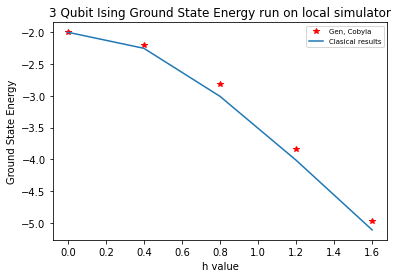

In [15]:
plt.plot(h_value, Gen_mean_value, 'r*',label='Gen, Cobyla')
plt.plot(hvalue,np.real(cvalue), '-',label='Clasical results')
plt.legend(loc='best',fontsize='x-small')
# plt.title('Quantum deviation of 3 qubit Ising energy to classical solver (PSR)')
plt.title('3 Qubit Ising Ground State Energy run on local simulator')
plt.ylabel('Ground State Energy')
plt.xlabel('h value')
plt.show()

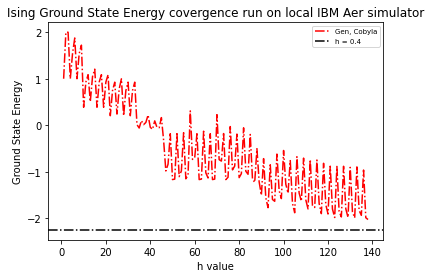

In [41]:
plt.plot(Gen_counts[462:600],Gen_values[462:600], 'r-.',label='Gen, Cobyla')
plt.axhline(y=-2.2530643775397525, color='black', linestyle='-.',label = 'h = 0.4')
plt.legend(loc='best',fontsize='x-small')
# plt.title('Quantum deviation of 3 qubit Ising energy to classical solver (PSR)')
plt.title('Ising Ground State Energy covergence run on local IBM Aer simulator')
plt.ylabel('Ground State Energy')
plt.xlabel('h value')
plt.show()

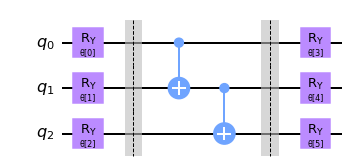

In [17]:
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
real.decompose().draw('mpl')

In [18]:
f1 = open("2quibitIsing_exact_simulator_RealAns.txt", "w")
f1.write('\n local_simulator \n ')
realvalue = []
h_value= []
tol = 1e-3
for i in range(5):
    h = 4*i/10
    h_value.append(h)
    # VQE solver, RealAmplitude ansatz
    parameter = [0 for i in range(real.num_parameters)]
    re = minimize(vqe_exact,parameter,args=(real,q, h,f1),method="COBYLA",tol=tol)
    realvalue.append(re.fun)
    f1.write(f'\n {h} : {re.fun} \n {re}')
f1.close()

In [19]:
real_mean_value =[]
real_counts = []
real_values = []
f = open("2quibitIsing_exact_simulator_RealAns.txt", "rt")
Extr_data(f,real_mean_value,real_counts,real_values)
f.close()

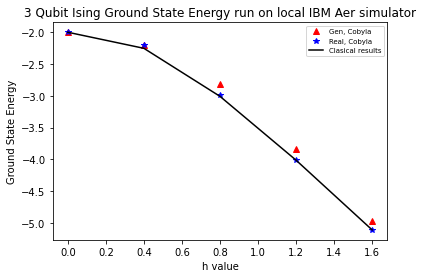

In [20]:
plt.plot(h_value, Gen_mean_value, 'r^',label='Gen, Cobyla')
plt.plot(h_value, real_mean_value, 'b*',label='Real, Cobyla')
plt.plot(hvalue,np.real(cvalue), '-',color='black',label='Clasical results')
plt.legend(loc='best',fontsize='x-small')
# plt.title('Quantum deviation of 3 qubit Ising energy to classical solver (PSR)')
plt.title('3 Qubit Ising Ground State Energy run on local IBM Aer simulator')
plt.ylabel('Ground State Energy')
plt.xlabel('h value')
plt.show()

In [21]:
# Calculate the discrepancy for comparing the accurate
Gen_discre = []
real_discre = []
for i in range(5):
    Gen_discre.append(Gen_mean_value[i] - np.real(cvalue[i]))
    real_discre.append(real_mean_value[i] - np.real(cvalue[i]))

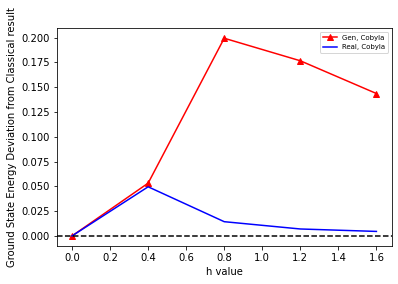

In [22]:
plt.plot(h_value, Gen_discre, 'r-^',label='Gen, Cobyla')
plt.plot(h_value, real_discre, 'b-',label='Real, Cobyla')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small')
# plt.title('3 Qubit Ising Ground State Energy deviation from the classical solver')
plt.ylabel('Ground State Energy Deviation from Classical result')
plt.xlabel('h value')
plt.show()

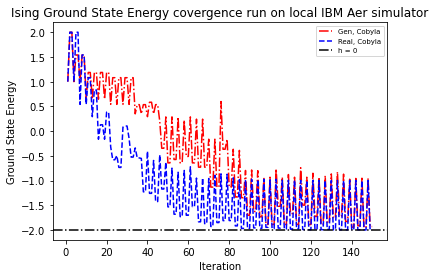

In [29]:
plt.plot(Gen_counts[0:150],Gen_values[0:150], 'r-.',label='Gen, Cobyla')
plt.plot(real_counts[0:150],real_values[0:150], 'b--',label='Real, Cobyla')
plt.axhline(y=-2, color='black', linestyle='-.',label = 'h = 0')
plt.legend(loc='best',fontsize='x-small')
# plt.title('Quantum deviation of 3 qubit Ising energy to classical solver (PSR)')
plt.title('Ising Ground State Energy covergence run on local IBM Aer simulator')
plt.ylabel('Ground State Energy')
plt.xlabel('Iteration')
plt.show()

# Parameter-shift rules

In [99]:
q = 3
l_rate = 0.3
numberofiteration = 200

psr_itera = []
psr_itera_value = []
psr_mean_value = []
for y in range(5):
    h = 4*y/10
    parameters = [0 for i in range(real.num_parameters)]
    for j in range(numberofiteration):
        psr_itera.append(j)
        Dvqe = [0 for i in range(len(parameters))]
        psr_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            psr_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2
            Dvqe[i] = (1/2*(vqe_exact([psr_parameters[i] + PSR_parameter[i] for i in range(len(psr_parameters))],real,q,h)-vqe_exact([psr_parameters[i] - PSR_parameter[i] for i in range(len(psr_parameters))],real,q,h)))
            parameters[i]-=l_rate*Dvqe[i]
        psr_itera_value.append(vqe_exact(parameters,real,q,h))
    psr_mean_value.append(vqe_exact(parameters,real,q,h))

In [100]:
# Calculate the discrepancy for comparing the accurate
real_discre_prs = []
real_discre = []
for i in range(5):
    real_discre_prs.append(psr_mean_value[i] - np.real(cvalue[i]))
    real_discre.append(real_mean_value[i] - np.real(cvalue[i]))

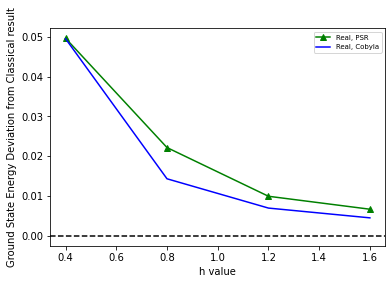

In [101]:
plt.plot(h_value[1:], real_discre_prs[1:], 'g-^',label='Real, PSR')
plt.plot(h_value[1:], real_discre[1:], 'b-',label='Real, Cobyla')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc='best',fontsize='x-small')
# plt.title('2 Qubit Ising Ground State Energy deviation from the classical solver')

plt.ylabel('Ground State Energy Deviation from Classical result')
plt.xlabel('h value')
plt.show()

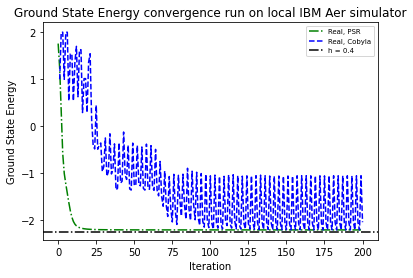

In [103]:
plt.plot(psr_itera[200:400],psr_itera_value[200:400], 'g-.',label='Real, PSR')
plt.plot(real_counts[234:434],real_values[234:434], 'b--',label='Real, Cobyla')
plt.axhline(y=-2.2530643775397525, color='black', linestyle='-.',label = 'h = 0.4')
plt.legend(loc='best',fontsize='x-small')
plt.title('Ground State Energy convergence run on local IBM Aer simulator')
plt.ylabel('Ground State Energy')
plt.xlabel("Iteration")
plt.show()